# Recommender System Examples: Grocery Customers
Building Recommender Systems: 
- "SmartBasket" - reminds customers of items they like and may have forgotten, &
- "Do You Want To Try?" - suggests new items to customers


#### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import random
import implicit
from sklearn.preprocessing import MinMaxScaler
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, KNNBasic, KNNWithMeans, KNNBaseline, CoClustering, BaselineOnly, NormalPredictor
from surprise.model_selection.validation import cross_validate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Read in data

In [2]:
df = pd.read_csv('C:/Users/scarl/Documents/Data/Grocery_Exhibits.csv',  
                   parse_dates=['Created On'])

df.head()

,Member,Order,SKU,Created On,Description
0,M09736,6468572,34993740,2014-09-22 22:45:00,Other Sauces
1,M09736,6468572,15669800,2014-09-22 22:45:00,Cashews
2,M09736,6468572,34989501,2014-09-22 22:45:00,Other Dals
3,M09736,6468572,7572303,2014-09-22 22:45:00,Namkeen
4,M09736,6468572,15669856,2014-09-22 22:45:00,Sugar


#### Data cleaning

In [3]:
df = df.replace(['CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,channa-dal,7832491,2,0\r\n7832360,Cheese,cheese,7832363,2,0\r\n7831689,Chewing Gum,chewing-gum,7831685,2,0\r\n7832047,ChildrenS Books'],'CFLs')
df.columns = df.columns.str.replace(' ','_') # removing spaces from feature names
df.Description = df.Description.str.replace(' ','_') # removing spaces from values

df.drop(['Order', 'SKU', 'Created_On'], axis=1, inplace=True) # dropping unncessessary features

df['Member'] = df['Member'].str[1:] # removing non-numerics from Member identifier
df['Member'] = pd.to_numeric(df['Member']) # converting to numeric

df['Sales'] = 1 # adding indicator

df.head()

,Member,Description,Sales
0,9736,Other_Sauces,1
1,9736,Cashews,1
2,9736,Other_Dals,1
3,9736,Namkeen,1
4,9736,Sugar,1


### Model 1: Did You Forget?
- This recommender system is built using collaborative filtering with implicit feedback.
- <i>Total</i> weights each members preference towards each item they have historically purchased. Each time the Member purchases an item, Total increases by 1.
- The model suggests recommendations to the customer based on their historic shopping patterns - the more time an item has been purchased, the higher we rate their preference towards that item.
- For example: Member 33064's most frequently purchased item is coffee, therefore, SmartBasket will remind Member 33064 to purchase coffee before checking out.
- We can adjust the number of recommendations made. It is currently set to 10, but an ideal number might be 20.

#### Did You Forget?: Feature Engineering & Preprocessing

In [4]:
df_user = df.groupby(['Member', 'Description'])['Sales'].count().reset_index()
df_user.head()

,Member,Description,Sales
0,4158,Almonds,8
1,4158,Aluminium_Foil_&_Cling_Wrap,9
2,4158,Avalakki_/_Poha,2
3,4158,Baking_Ingredients,2
4,4158,Banana,26


In [5]:
# Convert descriptions into categorical codes
df_user['Description'] = df_user['Description'].astype("category")
df_user['Description_ID'] = df_user['Description'].cat.codes

df_user.head()

,Member,Description,Sales,Description_ID
0,4158,Almonds,8,2
1,4158,Aluminium_Foil_&_Cling_Wrap,9,3
2,4158,Avalakki_/_Poha,2,5
3,4158,Baking_Ingredients,2,11
4,4158,Banana,26,12


#### Did You Forget?: Collaborative Filtering with Implicit Feedback using Alternating Least Squares (ALS)

In [6]:
sparse_description_member = sparse.csr_matrix((df_user['Sales'].astype(float), (df_user['Description_ID'], df_user['Member'])))
sparse_member_description = sparse.csr_matrix((df_user['Sales'].astype(float), (df_user['Member'], df_user['Description_ID'])))

model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50)

alpha = 15
data = (sparse_description_member * alpha).astype('double')
model.fit(data)

  0%|          | 0/50 [00:00<?, ?it/s]

#### Did You Forget?: Testing Model Output on Top 10 Most Frequently Purchased Items

In [7]:
Description_ID = df_user['Description_ID'].sample(random_state=42).to_string().split()[1]
print('Selected Description_ID is {}'.format(str(Description_ID)))

Selected Description_ID is 135


In [8]:
Description_ID = 135
n_recs = 10

member_vecs = model.user_factors
description_vecs = model.item_factors

description_norms = np.sqrt((description_vecs * description_vecs).sum(axis=1))

scores = description_vecs.dot(description_vecs[Description_ID]) / description_norms
top_idx = np.argpartition(scores, -n_recs)[-n_recs:]
recs = sorted(zip(top_idx, scores[top_idx] / description_norms[Description_ID]), key=lambda x: -x[1])

for item in recs:
    idx, score = item
    print(df_user['Description'].loc[df_user.Description_ID == idx].iloc[0])

Organic_Masalas_&_Spices
Sunflower_Oils
Chips
Other_Sweets
Honey
Exotic_Vegetables
Raw_Rice
Raw_Peanuts
Toor_Dal
Urad_Dal


#### Did You Forget?: Creating a function that returns the Top 10 Most Frequently Purchased Items for each Member

In [9]:
def smartbasket(Member, sparse_member_description, member_vecs, description_vecs, num_contents=10):
    member_interactions = sparse_member_description[Member,:].toarray()
    member_interactions = member_interactions.reshape(-1) + 1
    #member_interactions[member_interactions > 1] = 0
    rec_vector = member_vecs[Member,:].dot(description_vecs.T).toarray()
    
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = member_interactions * rec_vector_scaled
    description_idx = np.argsort(recommend_vector)[::-1][:num_contents]
    
    descriptions = []
    scores = []
    
    for idx in description_idx:
        descriptions.append(df_user.Description.loc[df_user.Description_ID == idx].iloc[0])
        scores.append(recommend_vector[idx])
        
    smartbasket_recs = pd.DataFrame({'Description': descriptions, 'score': scores})
    
    return smartbasket_recs

In [10]:
member_vecs = sparse.csr_matrix(model.user_factors)
description_vecs = sparse.csr_matrix(model.item_factors)

#### Did You Forget?: Testing Recommendations on Randomly Selected User

In [11]:
# Selecting a random user
user1 = df_user['Member'].sample(random_state=42).to_string().split()[1]
print('Selected User is Member #{}'.format(str(user1)))

Selected User is Member #33064


In [12]:
# Testing Recommendations for Member=33064
Member = 33064

smartbasket_recs = smartbasket(Member, sparse_member_description, member_vecs, description_vecs)

print(smartbasket_recs)

         Description       score
0              Beans  137.960110
1    Root_Vegetables  109.500932
2       Whole_Spices   88.780283
3   Gourd_&_Cucumber   84.426541
4   Other_Vegetables   67.268288
5  Exotic_Vegetables   58.596581
6         Other_Dals   54.360309
7          Moong_Dal   42.263751
8           Brinjals   41.370598
9           Toor_Dal   30.177912


### Model 2: Do You Want To Try?
- This recommender system suggests <b>new</b> products to Members <i>(i.e. items they have never purchased before)</i> based on the preferences of Members with similar shopping profiles
- For example: Helga often purchases coffee and bagels and Bill often purchased coffee and cream. <b>Do You Want To Try?</b> will suggest Helga tries cream while suggesting bagels to Bill.
- We can adjust the number of recommendations made. It is currently set to 10, but an ideal number might be 20.

#### Do You Want To Try?: Feature Engineering & Preprocessing

In [13]:
df.head()

,Member,Description,Sales
0,9736,Other_Sauces,1
1,9736,Cashews,1
2,9736,Other_Dals,1
3,9736,Namkeen,1
4,9736,Sugar,1


In [15]:
df_colab = df.groupby(['Member', 'Description'])['Sales'].count().reset_index()
df_colab['Rating'] = np.log(df_colab['Sales'])
df_colab.drop(['Sales'],axis=1,inplace=True)
df_colab.head()

,Member,Description,Rating
0,4158,Almonds,2.079442
1,4158,Aluminium_Foil_&_Cling_Wrap,2.197225
2,4158,Avalakki_/_Poha,0.693147
3,4158,Baking_Ingredients,0.693147
4,4158,Banana,3.258097


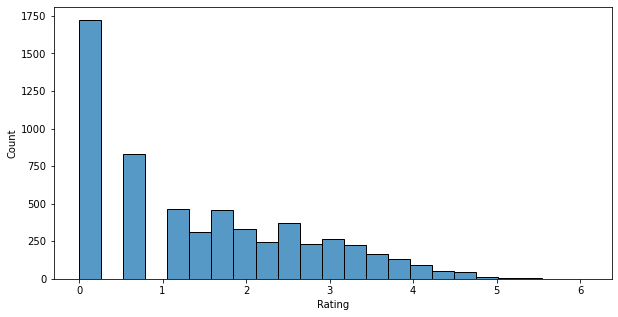

In [16]:
fig, axis = plt.subplots(figsize=(10,5))
axis = sns.histplot(x='Rating',data=df_colab)

In [17]:
reader = Reader()
data = Dataset.load_from_df(df_colab[['Member','Description','Rating']], reader)

#### Do You Want To Try?: Cross Validation

In [18]:
cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_validate(SVDpp(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_validate(SlopeOne(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_validate(KNNBasic(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_validate(KNNWithMeans(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_validate(KNNBaseline(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_validate(CoClustering(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_validate(BaselineOnly(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
cross_validate(NormalPredictor(), data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9789  0.9535  1.0081  0.9965  0.9964  0.9867  0.0190  
MAE (testset)     0.8238  0.8070  0.8471  0.8380  0.8218  0.8275  0.0139  
Fit time          0.22    0.22    0.22    0.22    0.23    0.22    0.01    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([0.97888744, 0.95351519, 1.00812073, 0.99647736, 0.99641681]),
 'test_mae': array([0.82383538, 0.80696748, 0.84708179, 0.83802483, 0.82182654]),
 'fit_time': (0.21793174743652344,
  0.21645426750183105,
  0.2174816131591797,
  0.2244570255279541,
  0.23041486740112305),
 'test_time': (0.007954120635986328,
  0.006960630416870117,
  0.006011009216308594,
  0.01198720932006836,
  0.006002664566040039)}

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9876  0.9484  0.9977  0.9566  0.9753  0.9731  0.0184  
MAE (testset)     0.8303  0.7852  0.8286  0.7960  0.8149  0.8110  0.0178  
Fit time          2.63    2.58    2.54    2.54    2.69    2.59    0.06    
Test time         0.05    0.05    0.05    0.05    0.05    0.05    0.00    


{'test_rmse': array([0.98756492, 0.94840364, 0.99767075, 0.95663197, 0.97528283]),
 'test_mae': array([0.83026237, 0.78518481, 0.82859634, 0.79602116, 0.81492804]),
 'fit_time': (2.6342384815216064,
  2.575570821762085,
  2.5357089042663574,
  2.5365798473358154,
  2.6916515827178955),
 'test_time': (0.04888319969177246,
  0.050902605056762695,
  0.04886937141418457,
  0.049866437911987305,
  0.05184221267700195)}

Evaluating RMSE, MAE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9748  0.9875  0.9869  0.9567  1.0139  0.9840  0.0187  
MAE (testset)     0.8181  0.8349  0.8337  0.8100  0.8415  0.8276  0.0117  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.04    0.03    0.03    0.03    0.03    0.04    0.00    


{'test_rmse': array([0.97484196, 0.98750596, 0.98689412, 0.95666857, 1.01391763]),
 'test_mae': array([0.81810853, 0.83489822, 0.83370502, 0.81      , 0.84150937]),
 'fit_time': (0.013964176177978516,
  0.007958650588989258,
  0.006982326507568359,
  0.0069849491119384766,
  0.00799107551574707),
 'test_time': (0.04288768768310547,
  0.03390240669250488,
  0.03487133979797363,
  0.03488302230834961,
  0.034921884536743164)}

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9422  0.9993  1.0083  0.9784  0.9788  0.9814  0.0228  
MAE (testset)     0.7879  0.8429  0.8461  0.8162  0.8041  0.8194  0.0224  
Fit time          0.01    0.02    0.01    0.01    0.01    0.01    0.00    
Test time         0.08    0.08    0.08    0.09    0.09    0.09    0.00    


{'test_rmse': array([0.94220338, 0.99928174, 1.00825124, 0.97843405, 0.97876305]),
 'test_mae': array([0.78785751, 0.84294228, 0.8460629 , 0.81621392, 0.80407984]),
 'fit_time': (0.012950897216796875,
  0.015941619873046875,
  0.014968633651733398,
  0.012920379638671875,
  0.013976812362670898),
 'test_time': (0.08282017707824707,
  0.08134961128234863,
  0.08376955986022949,
  0.09277224540710449,
  0.08974623680114746)}

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9703  0.9420  1.0038  0.9929  1.0049  0.9828  0.0239  
MAE (testset)     0.7973  0.7885  0.8475  0.8242  0.8370  0.8189  0.0226  
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.11    0.11    0.11    0.13    0.13    0.12    0.01    


{'test_rmse': array([0.97033612, 0.94199162, 1.00381444, 0.9929277 , 1.00491683]),
 'test_mae': array([0.79729704, 0.78848526, 0.84745139, 0.82418908, 0.83699819]),
 'fit_time': (0.0169827938079834,
  0.017960786819458008,
  0.015981197357177734,
  0.01876997947692871,
  0.01695418357849121),
 'test_time': (0.11067318916320801,
  0.10772323608398438,
  0.10919642448425293,
  0.12567591667175293,
  0.12671685218811035)}

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9791  0.9518  0.9728  1.0017  0.9772  0.9765  0.0159  
MAE (testset)     0.8170  0.7919  0.8079  0.8316  0.8262  0.8149  0.0141  
Fit time          0.02    0.02    0.02    0.02    0.02    0.02    0.00    
Test time         0.18    0.14    0.14    0.14    0.14    0.15    0.02    


{'test_rmse': array([0.97912615, 0.95176454, 0.97277325, 1.00169936, 0.97721049]),
 'test_mae': array([0.81695192, 0.79191625, 0.80794926, 0.83164073, 0.82616695]),
 'fit_time': (0.02094244956970215,
  0.01795649528503418,
  0.01797938346862793,
  0.018955230712890625,
  0.01796269416809082),
 'test_time': (0.1807103157043457,
  0.14261651039123535,
  0.14458727836608887,
  0.13862013816833496,
  0.14458489418029785)}

Evaluating RMSE, MAE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0243  1.0397  1.0380  1.0387  1.0260  1.0333  0.0067  
MAE (testset)     0.8548  0.8797  0.8883  0.8726  0.8668  0.8724  0.0113  
Fit time          0.11    0.10    0.10    0.10    0.10    0.10    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.02430495, 1.03967974, 1.03802876, 1.03865651, 1.02596959]),
 'test_mae': array([0.85482974, 0.87965509, 0.88826664, 0.87261742, 0.86684695]),
 'fit_time': (0.10771584510803223,
  0.10274767875671387,
  0.10076689720153809,
  0.10071825981140137,
  0.09972929954528809),
 'test_time': (0.006015777587890625,
  0.0059740543365478516,
  0.005961179733276367,
  0.0060155391693115234,
  0.0050029754638671875)}

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9979  1.0051  0.9534  1.0114  0.9673  0.9870  0.0226  
MAE (testset)     0.8425  0.8396  0.8073  0.8592  0.8131  0.8323  0.0194  
Fit time          0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Test time         0.00    0.01    0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.99786064, 1.00505302, 0.95344115, 1.01144557, 0.96728766]),
 'test_mae': array([0.84249139, 0.83959227, 0.80725857, 0.85921863, 0.81314582]),
 'fit_time': (0.003981351852416992,
  0.00298309326171875,
  0.004008054733276367,
  0.003987312316894531,
  0.003021717071533203),
 'test_time': (0.004015445709228516,
  0.005023479461669922,
  0.004967689514160156,
  0.004014015197753906,
  0.00399327278137207)}

Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5811  1.5914  1.5991  1.5695  1.6381  1.5958  0.0233  
MAE (testset)     1.2999  1.3043  1.2983  1.2863  1.3461  1.3070  0.0204  
Fit time          0.01    0.01    0.01    0.01    0.01    0.01    0.00    
Test time         0.01    0.01    0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.58112375, 1.59139358, 1.59908493, 1.56949332, 1.63805212]),
 'test_mae': array([1.29986856, 1.30428164, 1.29831033, 1.28634463, 1.34608641]),
 'fit_time': (0.006983280181884766,
  0.005988597869873047,
  0.0060002803802490234,
  0.005966663360595703,
  0.006981372833251953),
 'test_time': (0.007977485656738281,
  0.007997512817382812,
  0.006978034973144531,
  0.006978750228881836,
  0.006981372833251953)}

#### Do You Want To Try?: Make Recommendations

In [19]:
user = df_colab['Member'].sample(random_state=42).to_string().split()[1]
print('Selected User is user id #{}'.format(str(user)))

Selected User is user id #33064


In [20]:
svdpp = SVDpp()
trainset = data.build_full_trainset()
svdpp.fit(trainset)

recom = pd.DataFrame(df['Description'].unique(),columns=['Description'])
recom['Pred_Rating'] = recom['Description'].apply(lambda x: svdpp.predict(user,x).est)

recom = recom.sort_values(by=['Pred_Rating'], ascending=False)
user_df_colab = df_colab.loc[df_colab['Member']==33064]

recom = pd.merge(recom, user_df_colab, on='Description', how='outer')
recom[recom.isna().any(axis=1)][['Description','Pred_Rating','Rating']].head(10)

,Description,Pred_Rating,Rating
18,Organic_Dals_&_Pulses,1.795119,NaN
20,Health_Drinks,1.773031,NaN
27,Organic_Baby_Foods,1.603677,NaN
32,Frozen_Chicken,1.550505,NaN
33,Ghee,1.537044,NaN
36,Cashews,1.523652,NaN
37,Instant_Noodles,1.512435,NaN
39,Organic_Flours,1.485985,NaN
41,Eggs,1.470736,NaN
42,"Organic_Salt,Sugar_&_Jaggery",1.446511,NaN


#### Do You Want To Try?: Validation & Performance Measures

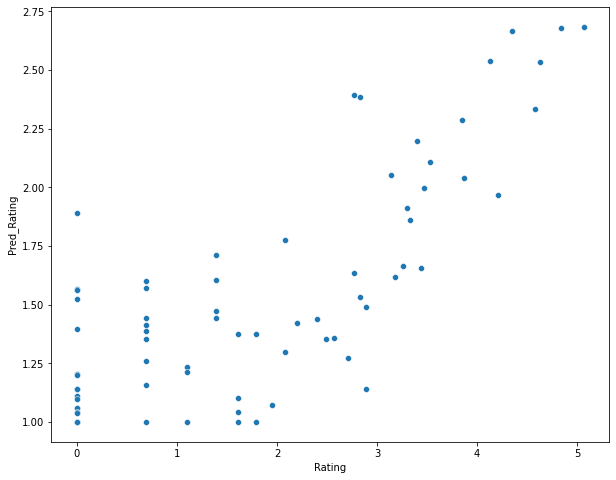

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.scatterplot(x=recom['Rating'], y=recom['Pred_Rating'], data=recom)